# Feature Extraction and Analysis
1. Feature Extraction of Pitch and Intensity
2. Normalization
3. Anlaysis

In [2]:
import os
import pandas as pd
import numpy as np
import parselmouth
from parselmouth.praat import call
import re
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter

## Data Load
- File (2,324 Wav)
    - speaker_session_emotion_start-time_content.wav
        - **7 speakers**: cc, cl, gg, jg, mf, mk, mm
            - ex) cc_001_anxiety_910.77_May-twenty-third.wav
                - speaker(cc), session(001), emotion(anxiety), start-time(910.77), content/script(May-twenty-thrid)
        - **15 emotions**: anxiety, boredom, cold-anger, contempt, despair, disgust, elation, happy, hot-anger, interest, neural, panic, pride, sadness, shame

In [4]:
wav_dir = "../hw3_speech_files"


data = []
for filename in os.listdir(wav_dir):
    if filename.endswith(".wav"):
        parts = filename.replace(".wav", "").split("_", maxsplit=4)
        if len(parts) == 5:
            speaker, session, emotion, start_time, content = parts
            data.append({
                "filename": filename,
                "speaker": speaker,
                "session": session,
                "emotion": emotion,
                "start_time": start_time,
                "content": content,
                "filepath": os.path.join(wav_dir, filename)
            })
df = pd.DataFrame(data)

In [7]:
df.head()

,filename,speaker,session,emotion,start_time,content,filepath
0,mf_001_interest_2590.84_Eight-hundred-two.wav,mf,001,interest,2590.84,Eight-hundred-two,../hw3_speech_files/mf_001_interest_2590.84_Ei...
1,mf_001_anxiety_1171.28_Six-hundred-one.wav,mf,001,anxiety,1171.28,Six-hundred-one,../hw3_speech_files/mf_001_anxiety_1171.28_Six...
2,cc_001_pride_2501.34_March-twenty-fifth.wav,cc,001,pride,2501.34,March-twenty-fifth,../hw3_speech_files/cc_001_pride_2501.34_March...
3,cc_001_boredom_2278.62_Six-hundred-six.wav,cc,001,boredom,2278.62,Six-hundred-six,../hw3_speech_files/cc_001_boredom_2278.62_Six...
4,jg_001_panic_443.70_Fifty-seven.wav,jg,001,panic,443.70,Fifty-seven,../hw3_speech_files/jg_001_panic_443.70_Fifty-...


## Feature Extraction
1. Extract **six features** from each speech segment using **Praat** and **Parselmouth**.
   - Pitch: min, max, mean
       - For Praat-based pitch extraction, please set the pitch range as 75~600 Hz, and use autocorrelation as the analysis method. 
   - Intensity: min, may, mean
       - For intensity extraction, please set the pitch floor to 75 Hz, and the time step to 0.0 or None.
        - Please use only the left channel (channel 1) for analysis in this section.

In [10]:
print(parselmouth.__version__)

0.4.5


- Extract Raw Features

In [13]:
def extract_raw_pitch(file_path, time_step=0.0, pitch_floor=75, pitch_ceiling=600):
    snd = parselmouth.Sound(file_path)
    
    # Pitch extraction (autocorrelation, 75–600 Hz)
    """
        To Pitch (ac): time_step, pitch_floor, max_candidates, very_accurate, 
                        silence_threshold, voicing_threshold, octave_cost, octave_jump_cost,
                        voiced_unvoiced_cost, pitch_ceiling
    """
    pitch = call(snd, "To Pitch (ac)", time_step, pitch_floor, 
                 15, "off", 0.03, 0.45, 0.01, 0.35, 0.14, pitch_ceiling)
    pitch_array = pitch.selected_array["frequency"]

    # exclude values that are 0 or NaN
    pitch_array = pitch_array[~np.isnan(pitch_array)]
    pitch_array = pitch_array[pitch_array>0]

    return pitch_array

In [15]:
def extract_raw_intensity(file_path, time_step=0.0, pitch_floor=75):
    snd = parselmouth.Sound(file_path)

    # Intensity extraction (75 Hz floor) & use only left channel
    subtract_mean = "yes"
    intensity = call(snd, "To Intensity", pitch_floor, time_step, subtract_mean)
    intensity_array = intensity.values[0] # use only channel 1

    # exclude values that are 0 or NaN
    intensity_array = intensity_array[~np.isnan(intensity_array)]
    intensity_array = intensity_array[intensity_array>0]
    
    return intensity_array

In [17]:
# extract pitch and intensity from filename (segmen-level)

raw_features = []

for i, row in tqdm(df.iterrows(), total=len(df)):
    filepath = row["filepath"]
    speaker = row["speaker"]
    filename = row["filename"]
    emotion = row["emotion"]

    pitch_array = extract_raw_pitch(filepath)
    intensity_array = extract_raw_intensity(filepath)

    # raw pitch - min, max, mean
    pitch_min, pitch_max, pitch_mean = np.min(pitch_array), np.max(pitch_array), np.mean(pitch_array)

    # raw intensity - min, max, mean
    intensity_min, intensity_max, intensity_mean = np.min(intensity_array), np.max(intensity_array), np.mean(intensity_array)
    
    raw_features.append({
        "filename": filename,
        "speaker": speaker,
        "emotion": emotion,
        "pitch_array": pitch_array,
        "intensity_array": intensity_array,
        "pitch_min_raw": pitch_min,
        "pitch_max_raw": pitch_max,
        "pitch_mean_raw": pitch_mean,
        "intensity_min_raw": intensity_min,
        "intensity_max_raw": intensity_max,
        "intensity_mean_raw": intensity_mean
    })

raw_df = pd.DataFrame(raw_features)

100%|██████████████████████████████████████| 2324/2324 [00:06<00:00, 349.42it/s]


In [18]:
raw_df.head()

,filename,speaker,emotion,pitch_array,intensity_array,pitch_min_raw,pitch_max_raw,pitch_mean_raw,intensity_min_raw,intensity_max_raw,intensity_mean_raw
0,mf_001_interest_2590.84_Eight-hundred-two.wav,mf,interest,"[147.61835093558605, 146.88637319738152, 155.7...","[67.59469365894608, 67.6986717817256, 67.45391...",136.706006,396.699742,298.640085,36.614690,68.700588,55.459283
1,mf_001_anxiety_1171.28_Six-hundred-one.wav,mf,anxiety,"[162.04235108975703, 159.36853694759952, 155.7...","[45.12859828944403, 47.51880799670061, 50.0611...",146.910323,240.097190,164.339495,45.128598,71.034028,63.217935
2,cc_001_pride_2501.34_March-twenty-fifth.wav,cc,pride,"[137.41666301265246, 136.17449197038164, 141.3...","[38.29787682413948, 50.03917124188712, 57.6147...",92.859850,563.976473,150.376392,36.655536,70.336489,54.616907
3,cc_001_boredom_2278.62_Six-hundred-six.wav,cc,boredom,"[111.36167226450702, 112.03084373200733, 107.9...","[33.667183652346885, 31.687729792455265, 32.76...",88.458167,218.513929,128.143332,31.687730,67.037833,54.804441
4,jg_001_panic_443.70_Fifty-seven.wav,jg,panic,"[232.7958724531116, 219.8052357237019, 207.409...","[30.59913120724033, 32.4447219921277, 35.22801...",146.097492,232.795872,177.215006,29.769395,63.692273,45.360042


In [19]:
raw_df.describe()

,pitch_min_raw,pitch_max_raw,pitch_mean_raw,intensity_min_raw,intensity_max_raw,intensity_mean_raw
count,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000
mean,144.508300,374.966690,225.885146,37.057653,75.941924,59.574162
std,61.613467,155.973279,87.139629,7.040124,6.079626,6.119665
min,74.886730,98.522441,80.950962,7.670332,53.403073,29.859855
25%,92.140956,240.037827,157.639435,32.550513,71.949909,55.505481
50%,129.850187,368.611989,218.158854,37.214278,75.904770,59.565277
75%,182.589798,531.605007,276.865451,41.911083,80.132789,63.617430
max,464.472139,599.990828,532.334435,67.476922,92.928329,81.521196


In [20]:
raw_df.isna().sum()

filename              0
speaker               0
emotion               0
pitch_array           0
intensity_array       0
pitch_min_raw         0
pitch_max_raw         0
pitch_mean_raw        0
intensity_min_raw     0
intensity_max_raw     0
intensity_mean_raw    0
dtype: int64

In [25]:
raw_df.groupby("speaker")[[
    "pitch_min_raw", "pitch_max_raw", "pitch_mean_raw",
    "intensity_min_raw", "intensity_max_raw", "intensity_mean_raw"
]].describe()

pitch_min_raw                                                \
                count        mean        std        min         25%   
speaker                                                               
cc              265.0  108.685141  39.532566  75.053210   84.607759   
cl              368.0   98.502264  40.584764  74.886730   76.998449   
gg              420.0  155.008937  50.008392  74.913361  120.185445   
jg              273.0  155.299804  51.029727  74.919216  122.619456   
mf              299.0  125.824654  42.183310  74.971379  101.522259   
mk              397.0  204.171066  61.438403  75.002850  176.277244   
mm              302.0  147.711286  65.784919  74.915104  108.793726   

                                            pitch_max_raw              ...  \
                50%         75%         max         count        mean  ...   
speaker                                                                ...   
cc        91.153227  108.207978  269.939135         265.0  295.619853  ...   
cl        80.773654   95.705313  304.818517         368.0  311.793843  ...   
gg       146.405944  177.153647  384.449000         420.0  410.578666  ...   
jg       155.885851  185.654558  344.213220         273.0  421.005389  ...   
mf       111.983582  135.331056  319.617132         299.0  301.283139  ...   
mk       201.687576  229.550734  421.892394         397.0  460.278911  ...   
mm       132.221199  159.809683  464.472139         302.0  391.229452  ...   

        intensity_max_raw            intensity_mean_raw                       \
                      75%        max              count       mean       std   
speaker                                                                        
cc              79.365495  88.824089              265.0  60.614530  5.089717   
cl              80.169757  92.697876              368.0  56.313754  4.911339   
gg              81.549228  89.318736              420.0  63.521636  5.078856   
jg              81.365339  92.529300              273.0  55.169742  6.106364   
mf              78.686411  92.375596              299.0  61.823496  6.825404   
mk              79.972388  92.928329              397.0  58.561519  4.865948   
mm              78.712714  89.163175              302.0  60.230019  5.470316   

                                                                
               min        25%        50%        75%        max  
speaker                                                         
cc       29.859855  57.701320  61.229012  64.059757  71.980755  
cl       42.116715  53.601092  56.392417  59.213142  71.764119  
gg       49.104391  60.703355  63.717327  66.777304  81.521196  
jg       41.435198  50.522341  54.490813  59.305458  69.982291  
mf       44.311171  57.014555  61.906978  65.957434  80.536830  
mk       44.925370  55.099283  58.624909  61.596160  77.756231  
mm       39.674361  56.900595  60.219645  63.311179  75.901566  

[7 rows x 48 columns]

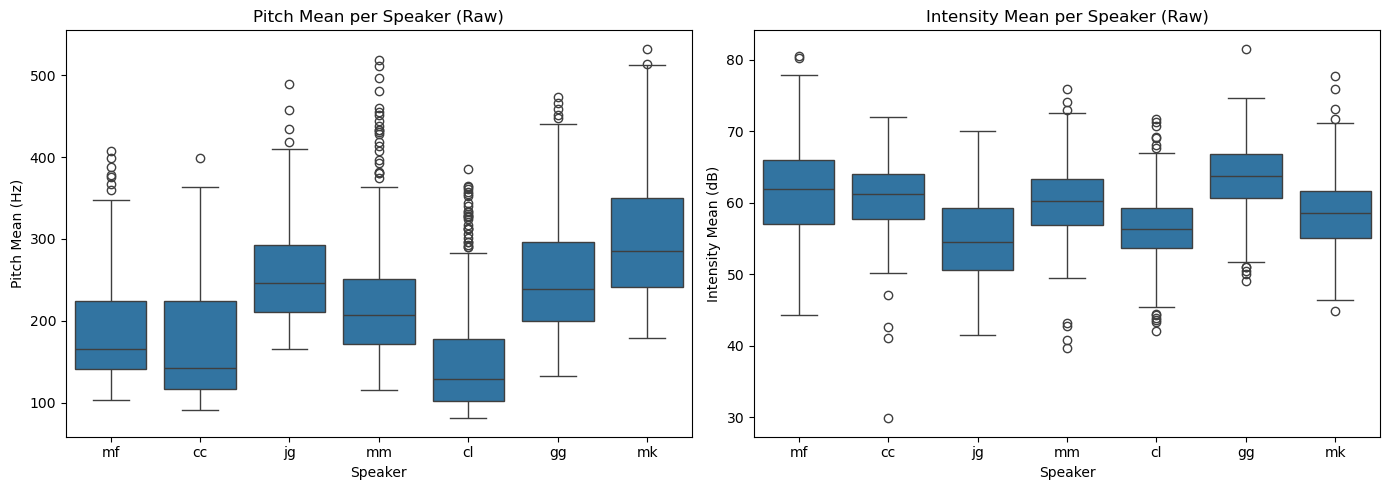

In [27]:
plt.figure(figsize=(14, 5))

# left: pitch mean per speaker
plt.subplot(1, 2, 1)
sns.boxplot(x="speaker", y="pitch_mean_raw", data=raw_df)
plt.title("Pitch Mean per Speaker (Raw)")
plt.xlabel("Speaker")
plt.ylabel("Pitch Mean (Hz)")

# right: intensity mean per speaker
plt.subplot(1, 2, 2)
sns.boxplot(x="speaker", y="intensity_mean_raw", data=raw_df)
plt.title("Intensity Mean per Speaker (Raw)")
plt.xlabel("Speaker")
plt.ylabel("Intensity Mean (dB)")

plt.tight_layout()
plt.show()

In [29]:
Counter(df['emotion'])

Counter({'contempt': 180,
         'happy': 177,
         'interest': 176,
         'despair': 174,
         'disgust': 172,
         'anxiety': 170,
         'elation': 159,
         'boredom': 154,
         'cold-anger': 154,
         'sadness': 151,
         'pride': 150,
         'shame': 148,
         'panic': 141,
         'hot-anger': 139,
         'neutral': 79})

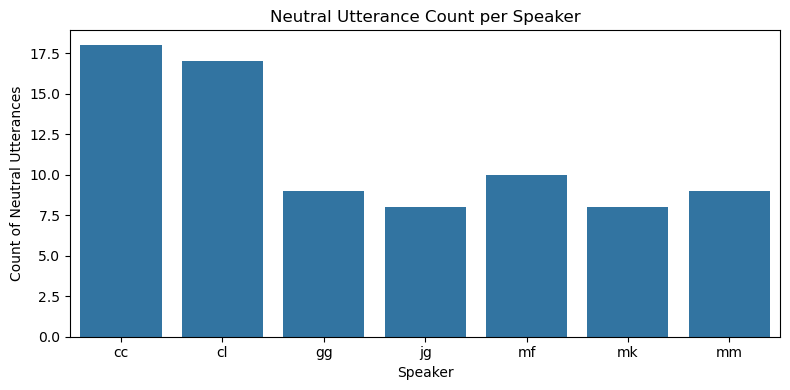

In [31]:
neutral_df = df[df["emotion"] == "neutral"]
speaker_counts = neutral_df["speaker"].value_counts().sort_index()

plt.figure(figsize=(8, 4))
sns.barplot(x=speaker_counts.index, y=speaker_counts.values)
plt.ylabel("Count of Neutral Utterances")
plt.xlabel("Speaker")
plt.title("Neutral Utterance Count per Speaker")
plt.tight_layout()
plt.show()

## Feature Preprocessing: Normalization
2. Normalize the features according by speaker (Since each speaker naturally has a different pitch range and other voice qualities like intensity)
   1. **Z-score normalization** (standardization) over the individual speaker is one common method. For example, if you would like to normalize the pitch features of an individual speaker X, the steps to Z-score normalization can be:
        1. Extract raw pitch values for all speech segments from speaker X. This would result in one array of pitch/frequency values for each segment. You can get it by calling pitch_array = pitch.selected_array["frequency"]
        2. Concatenate all pitch arrays from speaker X and calculate an overall mean pitch (𝜇𝑋) and pitch std (𝜎𝑋) of speaker X.
        3. Normalize each extracted pitch array – for each value 𝒙 in an array, calculate the normalized 𝒙 as (𝒙 - 𝜇𝑋) / 𝜎𝑋.
        4. Finally, calculate the min, max, and mean of pitch for each segment using the normalized pitch array.
        5. *Note: You are supposed to obtain an overall pitch/intensity mean and std value for **each speaker instead of each feature**, in order to normalize by the speaker. Do not get a mean value of mean pitches, rather, get an overall mean value of all pitch values from all segments
    2. Another method you may want to try is **normalizing by the means of the individual speaker’s neutral utterances**. For example, to normalize the min pitch values of an individual speaker X,
        1. Extract pitch values for all speech segments from speaker X, and obtain a min pitch value for each.
        2. Calculate an overall mean of min pitch (𝜇𝑚𝑖𝑛𝑝𝑖𝑡𝑐ℎ_𝑋) of speaker X by averaging the min pitch values of all neutral segments from speaker X.
        3. Normalize each min pitch value – for each min pitch 𝑥𝒎𝒊𝒏 of a segment, calculate the normalized 𝑥𝒎𝒊𝒏 as 𝑥𝒎𝒊𝒏 - 𝜇𝑚𝑖𝑛𝑝𝑖𝑡𝑐ℎ_𝑋.
    - You can either pick one of the normalization methods above or use other methods you find helpful. Please specify your method and provide a detailed description of how you calculated it and why you chose it. **You should exclude values of pitch and intensity that are 0 or NaN**.

- Normalization: Z-score normalization over the individual speaker
    1. Collect raw feature(pitch/intensity) array by speakers
    2. Calculate overall mean and std by speakers
    3. Perform Z-score normalization

In [35]:
# 1. collect raw feature array by the individual speakers

speaker_pitch_values = defaultdict(list)
speaker_intensity_values = defaultdict(list)

for _, row in raw_df.iterrows():
    speaker_pitch_values[row["speaker"]].extend(row["pitch_array"])
    speaker_intensity_values[row["speaker"]].extend(row["intensity_array"])

In [37]:
# speaker_pitch_values["cc"]

In [39]:
# speaker_intensity_values["mm"]

In [41]:
# 2. get OVERALL mean/std by the individual speakers

def get_speaker_stats(speaker_pitch_values, speaker_intensity_values):
    speaker_stats = {}
    
    for speaker in raw_df["speaker"].unique():
        pitch_all = np.array(speaker_pitch_values[speaker])
        intensity_all = np.array(speaker_intensity_values[speaker])
    
        pitch_mean, pitch_std = np.mean(pitch_all), np.std(pitch_all)
        intensity_mean, intensity_std = np.mean(intensity_all), np.std(intensity_all)
    
        speaker_stats[speaker] = {
            "pitch_mean": pitch_mean,
            "pitch_std": pitch_std,
            "intensity_mean": intensity_mean,
            "intensity_std": intensity_std
        }
    return speaker_stats

In [43]:
speaker_stats = get_speaker_stats(speaker_pitch_values, speaker_intensity_values)

print(pd.DataFrame.from_dict(speaker_stats, orient="index"))

    pitch_mean   pitch_std  intensity_mean  intensity_std
mf  192.611180   87.027605       61.764497      11.762053
cc  175.528953   91.332255       57.927207      14.569117
jg  255.948127   91.518895       55.344661      14.179310
mm  229.381680  108.017197       60.098054      11.268872
cl  155.349800  103.753304       56.294933      14.840809
gg  256.393090  102.187490       63.409916      11.207490
mk  302.764056  106.242946       58.365196      12.011213


In [45]:
# 3. Normalized (x-mean)/std, which x is the element of the feature array

normalized_rows = []

for _, row in raw_df.iterrows():
    speaker = row["speaker"]
    pitch_array = np.array(row["pitch_array"])
    intensity_array = np.array(row["intensity_array"])
    
    stats = speaker_stats[speaker]
    pitch_array_norm = (pitch_array - stats["pitch_mean"]) / stats["pitch_std"]
    intensity_array_norm = (intensity_array - stats["intensity_mean"]) / stats["intensity_std"]
    
    normalized_rows.append({
        "filename": row["filename"],
        "speaker": speaker,
        "emotion": row["emotion"],
        "pitch_array_norm": pitch_array_norm,
        "intensity_array_norm": intensity_array_norm,
        "pitch_min_norm": np.min(pitch_array_norm),
        "pitch_max_norm": np.max(pitch_array_norm),
        "pitch_mean_norm": np.mean(pitch_array_norm),
        "intensity_min_norm": np.min(intensity_array_norm),
        "intensity_max_norm": np.max(intensity_array_norm),
        "intensity_mean_norm": np.mean(intensity_array_norm)
    })

normalized_df = pd.DataFrame(normalized_rows)

In [47]:
normalized_df.head()

,filename,speaker,emotion,pitch_array_norm,intensity_array_norm,pitch_min_norm,pitch_max_norm,pitch_mean_norm,intensity_min_norm,intensity_max_norm,intensity_mean_norm
0,mf_001_interest_2590.84_Eight-hundred-two.wav,mf,interest,"[-0.5169949201976874, -0.5254057886932291, -0....","[0.4956785335088538, 0.5045186675428964, 0.483...",-0.642384,2.345101,1.218336,-2.138216,0.589701,-0.536064
1,mf_001_anxiety_1171.28_Six-hundred-one.wav,mf,anxiety,"[-0.35125440358855503, -0.38197815098881016, -...","[-1.4143703207980474, -1.211156667610397, -0.9...",-0.525131,0.545643,-0.324859,-1.414370,0.788088,0.123570
2,cc_001_pride_2501.34_March-twenty-fifth.wav,cc,pride,"[-0.4172927678640202, -0.43089334123807016, -0...","[-1.3473246724306385, -0.5414217002844751, -0....",-0.905147,4.253125,-0.275396,-1.460052,0.851753,-0.227214
3,cc_001_boredom_2278.62_Six-hundred-six.wav,cc,boredom,"[-0.7025697557919711, -0.6952429744278518, -0....","[-1.6651677702583898, -1.8010341996447055, -1....",-0.953341,0.470644,-0.518827,-1.801034,0.625338,-0.214341
4,jg_001_panic_443.70_Fifty-seven.wav,jg,panic,"[-0.2529778638224491, -0.39492272407209283, -0...","[-1.7451857893890037, -1.6150249530038514, -1....",-1.200306,-0.252978,-0.860294,-1.803703,0.588718,-0.704168


In [49]:
normalized_df.describe()

,pitch_min_norm,pitch_max_norm,pitch_mean_norm,intensity_min_norm,intensity_max_norm,intensity_mean_norm
count,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000
mean,-0.834217,1.481870,-0.014563,-1.758494,1.310917,0.026545
std,0.538627,1.459062,0.713928,0.544625,0.492893,0.441493
min,-2.143777,-0.904523,-1.206272,-3.855171,-0.417897,-1.926496
25%,-1.109512,0.137936,-0.553339,-2.123198,1.002277,-0.245531
50%,-0.889233,1.303095,-0.206369,-1.687693,1.308812,0.034535
75%,-0.669941,2.736967,0.363948,-1.394999,1.647066,0.301637
max,2.176417,4.672103,2.678574,0.362883,2.877572,1.615998


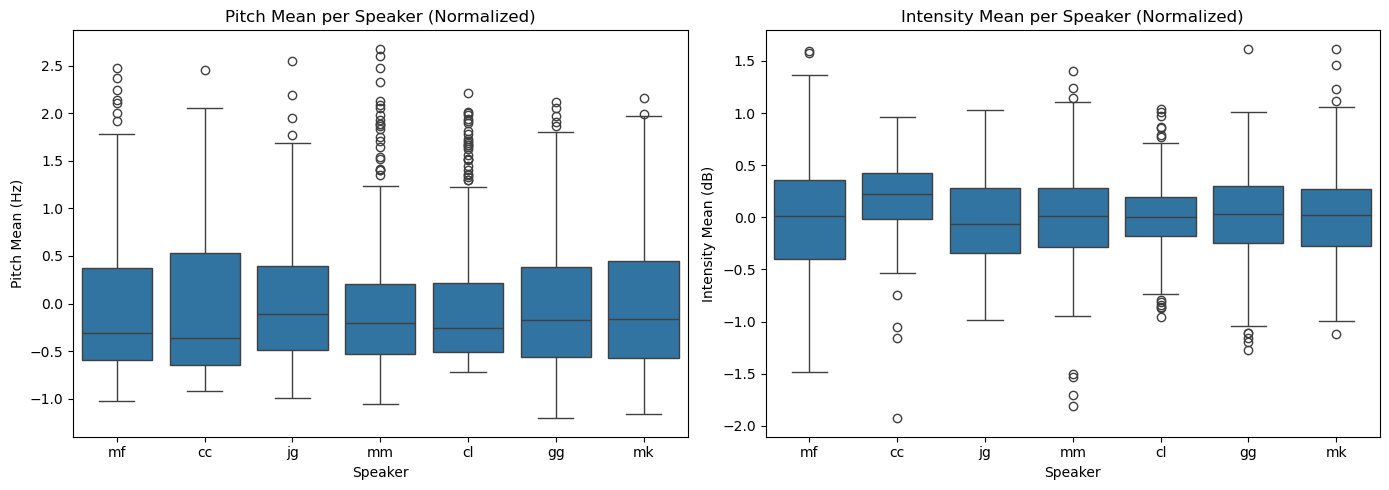

In [51]:
plt.figure(figsize=(14, 5))

# left: pitch mean per speaker
plt.subplot(1, 2, 1)
sns.boxplot(x="speaker", y="pitch_mean_norm", data=normalized_df)
plt.title("Pitch Mean per Speaker (Normalized)")
plt.xlabel("Speaker")
plt.ylabel("Pitch Mean (Hz)")

# right: intensity mean per speaker
plt.subplot(1, 2, 2)
sns.boxplot(x="speaker", y="intensity_mean_norm", data=normalized_df)
plt.title("Intensity Mean per Speaker (Normalized)")
plt.xlabel("Speaker")
plt.ylabel("Intensity Mean (dB)")

plt.tight_layout()
plt.show()

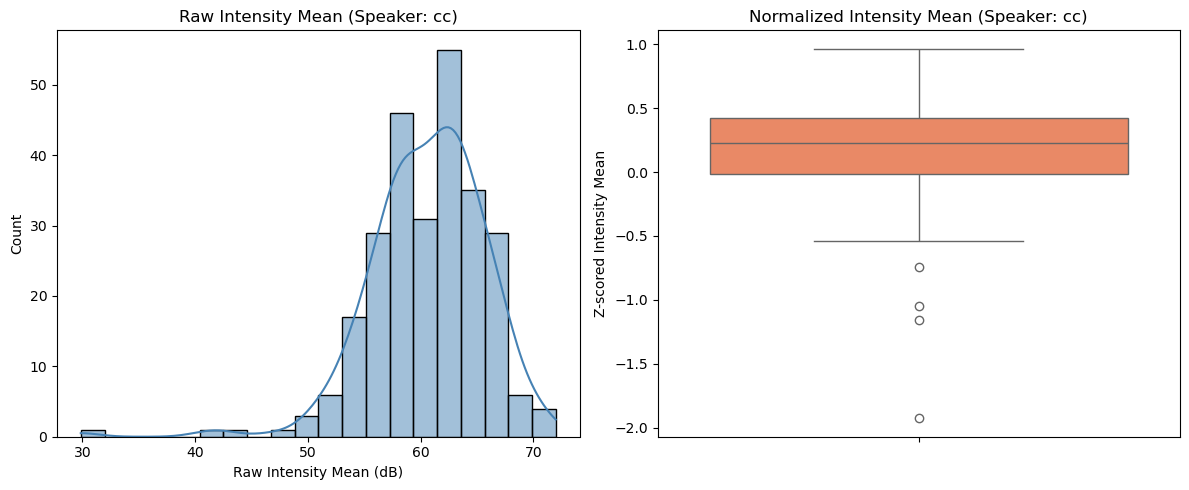

In [53]:
# cc speaker analysis

cc_raw = raw_df[raw_df["speaker"] =="cc"]
cc_norm = normalized_df[normalized_df["speaker"] =="cc"]

plt.figure(figsize=(12,5))

# 1. Raw Intensity Histogram
plt.subplot(1, 2, 1)
sns.histplot(cc_raw["intensity_mean_raw"], bins=20, kde=True, color="steelblue")
plt.title("Raw Intensity Mean (Speaker: cc)")
plt.xlabel("Raw Intensity Mean (dB)")
plt.ylabel("Count")

# 2. Normalized Intensity Boxplot
plt.subplot(1, 2, 2)
sns.boxplot(y=cc_norm["intensity_mean_norm"], color="coral")
plt.title("Normalized Intensity Mean (Speaker: cc)")
plt.ylabel("Z-scored Intensity Mean")

plt.tight_layout()
plt.show()

## Feature Analysis
You need to turn in **plots of the mean and standard deviation of each feature for all of the 15 emotion classes**. Please also specify for each plot whether it was created **a) without normalization; b) with normalization** (tell us what normalization method you used, how you calculated it, and why you chose this method). Specifically, create 2 plots for each feature, one without normalization, and one with normalization. In each plot, visualize the **emotion-level** mean and standard deviation values (calculated using all speech files of a certain emotion) for all emotion classes. You can use graphs with **error bars** to visualize the mean and standard deviation, as illustrated in the examples in Figure 1, where the x-axes can be emotion classes, and the y-axes can be any one of the 6 feature values (e.g. min pitch, mean intensity, etc.). This will result in **12 (6 x 2) plots**. 

In addition, tell us what you learn from these plots. **Please report and discuss at least 5 interesting observations**.

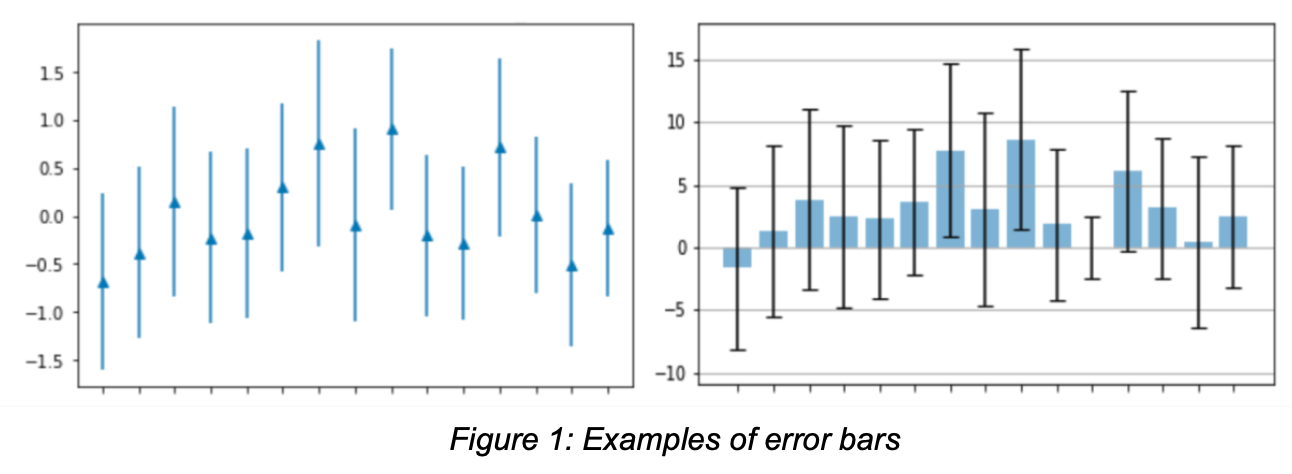

In [56]:
features = [
    ("pitch_min", "Pitch Min"),
    ("pitch_max", "Pitch Max"),
    ("pitch_mean", "Pitch Mean"),
    ("intensity_min", "Intensity Min"),
    ("intensity_max", "Intensity Max"),
    ("intensity_mean", "Intensity Mean"),
]

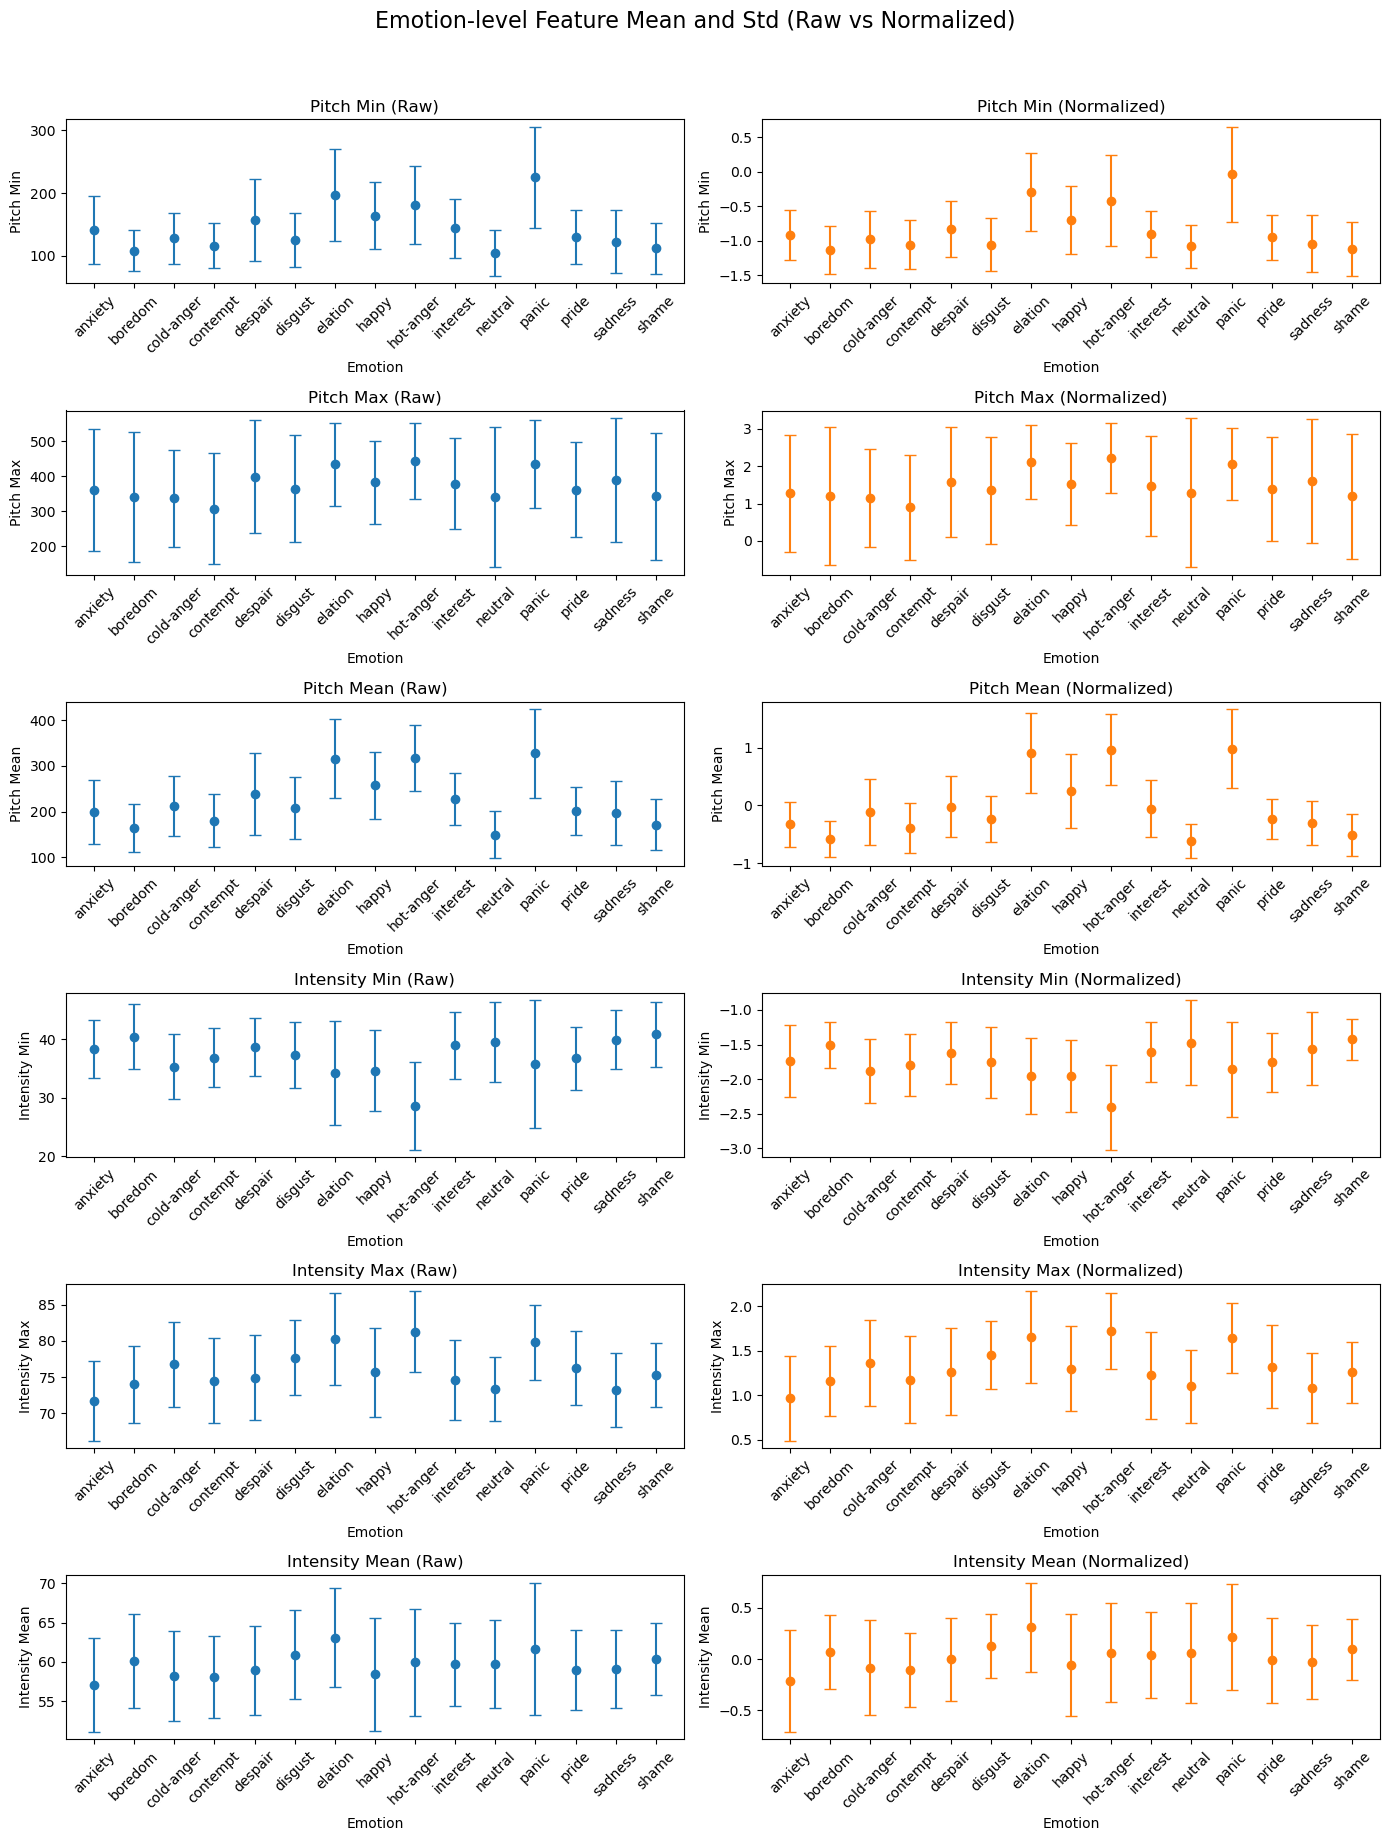

In [58]:
fig, axes = plt.subplots(6, 2, figsize=(14, 18))
plt.subplots_adjust(hspace=0.5)

for i, (col_base, label) in enumerate(features):
    # Raw statistics
    raw_stats = raw_df.groupby("emotion")[f"{col_base}_raw"].agg(['mean', 'std']).reset_index()
    axes[i, 0].errorbar(raw_stats["emotion"], raw_stats["mean"], yerr=raw_stats["std"],
                        fmt='o', capsize=4, color='tab:blue')
    axes[i, 0].set_title(f"{label} (Raw)")
    axes[i, 0].set_xlabel("Emotion")
    axes[i, 0].set_ylabel(label)
    axes[i, 0].tick_params(axis='x', rotation=45)

    # Normalized statistics
    norm_stats = normalized_df.groupby("emotion")[f"{col_base}_norm"].agg(['mean', 'std']).reset_index()
    axes[i, 1].errorbar(norm_stats["emotion"], norm_stats["mean"], yerr=norm_stats["std"],
                        fmt='o', capsize=4, color='tab:orange')
    axes[i, 1].set_title(f"{label} (Normalized)")
    axes[i, 1].set_xlabel("Emotion")
    axes[i, 1].set_ylabel(label)
    axes[i, 1].tick_params(axis='x', rotation=45)

plt.suptitle("Emotion-level Feature Mean and Std (Raw vs Normalized)", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

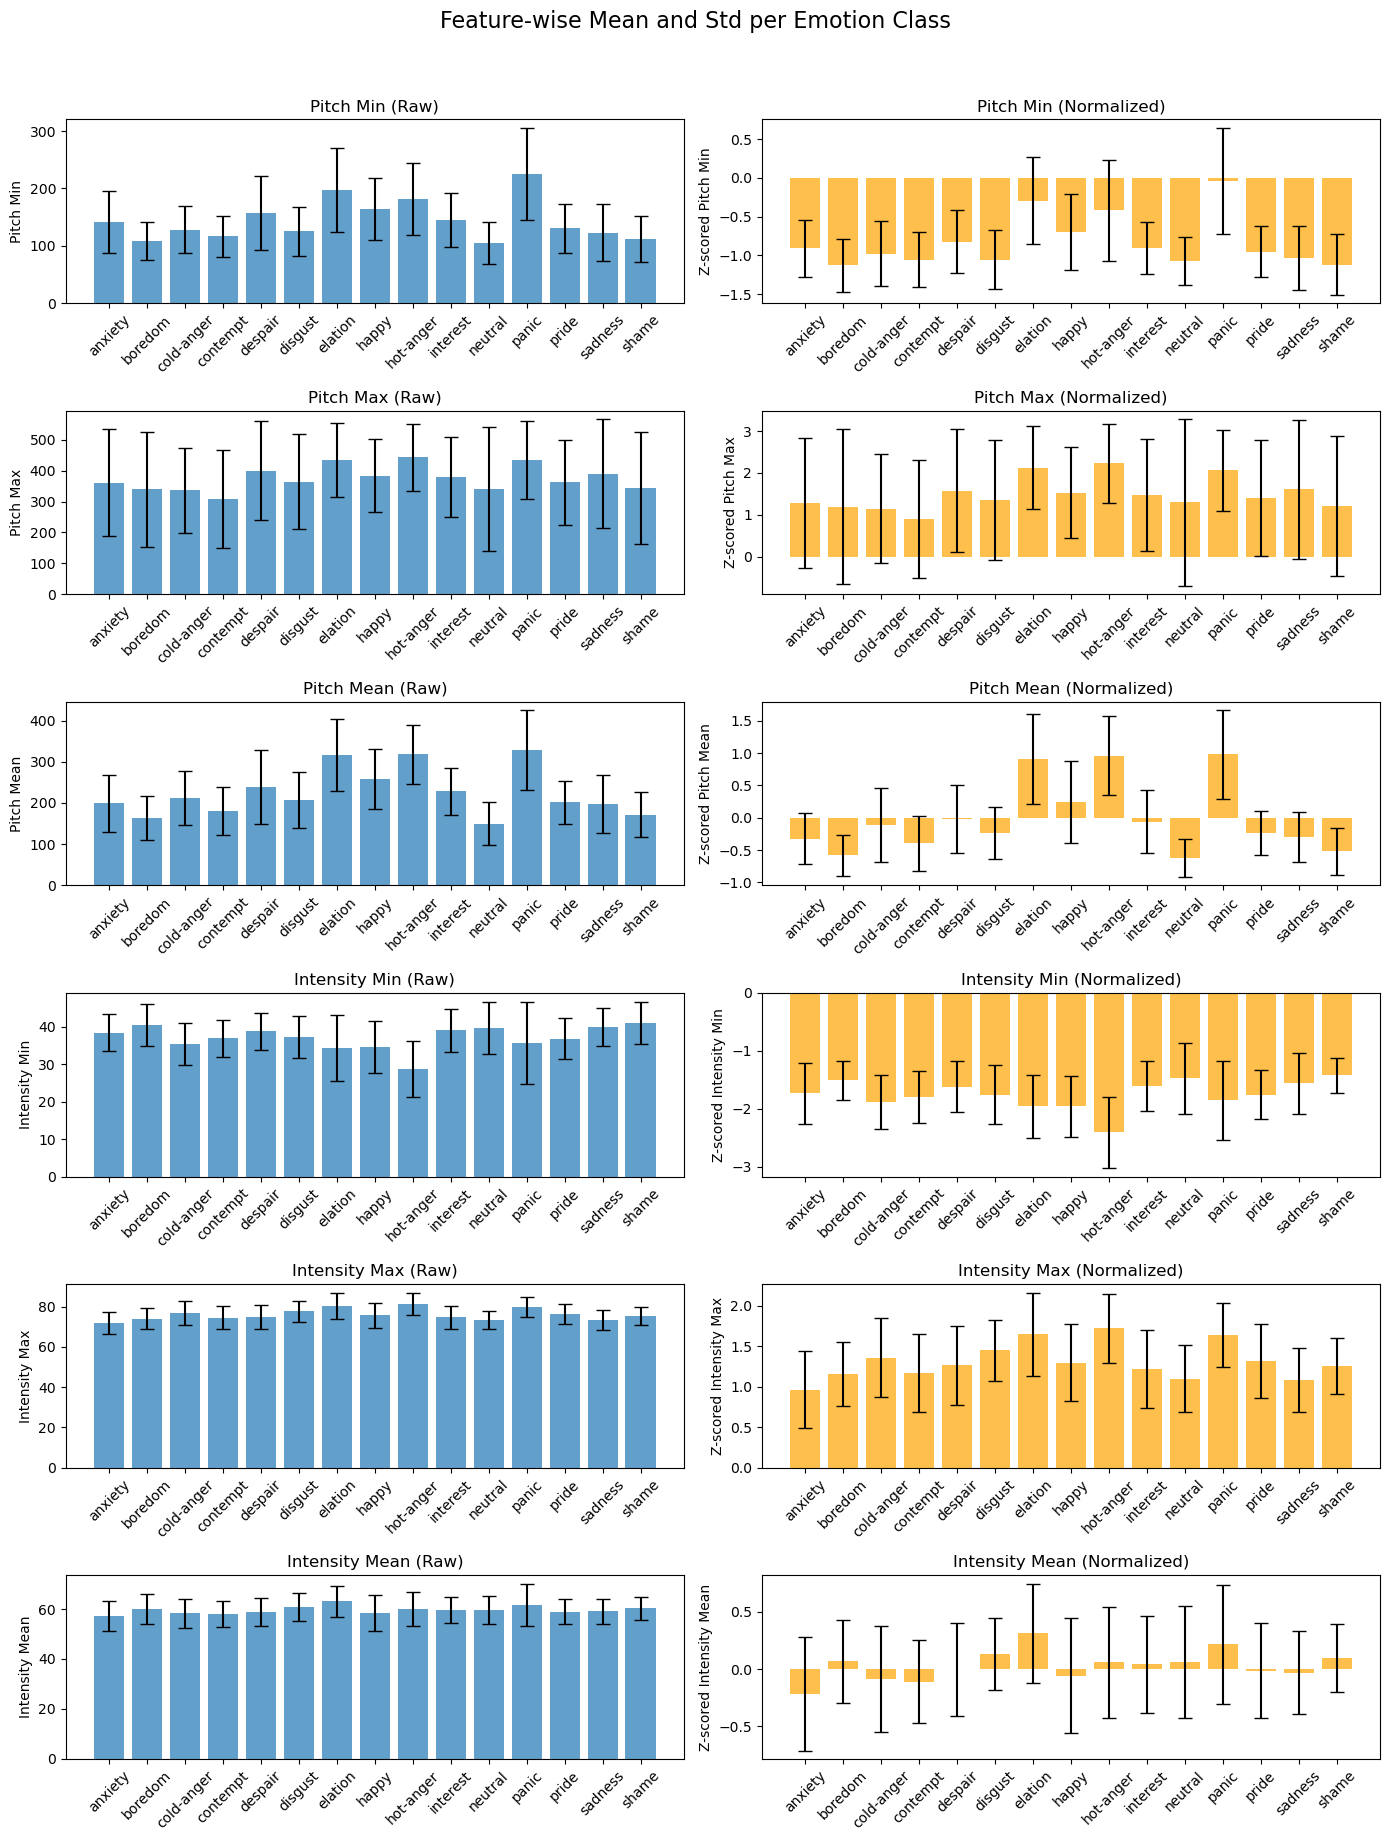

In [59]:
emotions = sorted(raw_df["emotion"].unique())
x = np.arange(len(emotions))  # Emotion index positions

fig, axes = plt.subplots(6, 2, figsize=(14, 18))
plt.subplots_adjust(hspace=0.6)

for i, (feat, label) in enumerate(features):
    # Raw data
    raw_stats = raw_df.groupby("emotion")[f"{feat}_raw"].agg(['mean', 'std']).reindex(emotions)
    axes[i, 0].bar(x, raw_stats['mean'], yerr=raw_stats['std'], capsize=5, alpha=0.7)
    axes[i, 0].set_title(f"{label} (Raw)")
    axes[i, 0].set_xticks(x)
    axes[i, 0].set_xticklabels(emotions, rotation=45)
    axes[i, 0].set_ylabel(label)

    # Normalized data
    norm_stats = normalized_df.groupby("emotion")[f"{feat}_norm"].agg(['mean', 'std']).reindex(emotions)
    axes[i, 1].bar(x, norm_stats['mean'], yerr=norm_stats['std'], capsize=5, alpha=0.7, color='orange')
    axes[i, 1].set_title(f"{label} (Normalized)")
    axes[i, 1].set_xticks(x)
    axes[i, 1].set_xticklabels(emotions, rotation=45)
    axes[i, 1].set_ylabel("Z-scored "+label)

plt.suptitle("Feature-wise Mean and Std per Emotion Class", fontsize=16, y=1.02)
plt.tight_layout()
plt.savefig("feature_analysis_emotion_errorbars.png", dpi=300, bbox_inches="tight")
plt.show()

In [64]:
normalized_df.to_csv("../task1_normalized_features.csv", index=False)